# RAFT IVF-PQ tutorial
In this tutorial you will learn to build IVF-PQ index and use it to search approximate nearest neighbors (ANN).
We will start with a brief overview of the functionality, but then dive into details to gain the understanding of the model parameters.
Along the way, we will benchmark the model and give some practical recommendations on how to maximize its performance for various use cases.

This tutorial uses the data from [ANN benchmarks website](https://ann-benchmarks.com).

In [1]:
import os
import tempfile
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import rmm
import urllib.request
import h5py

from rmm.allocators.cupy import rmm_cupy_allocator
from pylibraft.common import DeviceResources
from pylibraft.neighbors import ivf_pq, refine
from adjustText import adjust_text
from utils import calc_recall, load_dataset

%matplotlib inline

In [2]:
# A clumsy helper for inspecting properties of an object
def show_properties(obj):
    return {
        attr: getattr(obj, attr)
        for attr in dir(obj)
        if type(getattr(type(obj), attr)).__name__ == 'getset_descriptor'
    }

In [3]:
# We'll need to load store some data in this tutorial
WORK_FOLDER = os.path.join(tempfile.gettempdir(), 'raft_ivf_pq_tutorial')

if not os.path.exists(WORK_FOLDER):
   os.makedirs(WORK_FOLDER)
print("The index and data will be saved in", WORK_FOLDER)

The index and data will be saved in /tmp/raft_ivf_pq_tutorial


In [4]:
# Report the GPU in use to put the measurements into perspective
!nvidia-smi

Wed Mar 27 23:31:18 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   28C    P0    56W / 300W |  12892MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Use the pool memory resource
RAFT uses RMM allocator widely across its algorithms, including the performance-sensitive parts like IVF-PQ search.
It's strongly advised to set up the RMM pool memory resource to minimize the overheads of repeated CUDA allocations.


In [5]:
pool = rmm.mr.PoolMemoryResource(
    rmm.mr.CudaMemoryResource(),
    initial_pool_size=2**30
)
rmm.mr.set_current_device_resource(pool)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Get the data
The [ANN benchmarks website](https://ann-benchmarks.com) provides the datasets in [HDF5 format](https://www.hdfgroup.org/solutions/hdf5/).

The list of prepared datasets can be found at https://github.com/erikbern/ann-benchmarks/#data-sets

In [6]:
DATASET_URL = "http://ann-benchmarks.com/sift-128-euclidean.hdf5"
f = load_dataset(DATASET_URL)

The index and data will be saved in /tmp/raft_example


## Load the dataset

In [7]:
metric = f.attrs['distance']

dataset = cp.array(f['train'])
queries = cp.array(f['test'])
gt_neighbors = cp.array(f['neighbors'])
gt_distances = cp.array(f['distances'])

print(f"Loaded dataset of size {dataset.shape}; metric: '{metric}'.")
print(f"Number of test queries: {queries.shape[0]}")

Loaded dataset of size (1000000, 128); metric: 'euclidean'.
Number of test queries: 10000


## Build the index
Construction of the index generally consists of two phases: training (building the clusters) and filling-in (extending the index with data).
In the first phase, a balanced hierarchical k-means algorithm clusters the training data.
In the second phase, the new data is classified and added into the appropriate clusters in the index.
Hence, a user should call `ivf_pq.build` once and then possibly `ivf_pq.extend` several times.
Though for user convenience `ivf_pq.build` by default adds the whole training set into the index.

In [8]:
# RAFT's DeviceResources controls the GPU, cuda stream, memory policies etc.
# For now, we just create a default instance.
resources = DeviceResources()

In [9]:
# First, we need to initialize the build/indexing parameters.
# One of the more important parameters is the product quantisation (PQ) dim.
# Effectively, this parameter says
#      "shrink the dataset to this dimensionality to reduce the index size".
# It must be not bigger than the dataset dim,
# and it should be divisible by 32 for better GPU performance.
pq_dim = 1
while pq_dim * 2 < dataset.shape[1]:
    pq_dim = pq_dim * 2
# We'll use the ANN-benchmarks-provided metric and sensible defaults for the rest of parameters.
index_params = ivf_pq.IndexParams(n_lists=1024, metric=metric, pq_dim=pq_dim)

show_properties(index_params)

{'add_data_on_build': True,
 'codebook_kind': 0,
 'conservative_memory_allocation': False,
 'force_random_rotation': False,
 'kmeans_n_iters': 20,
 'kmeans_trainset_fraction': 0.5,
 'metric': 1,
 'n_lists': 1024,
 'pq_bits': 8,
 'pq_dim': 64}

In [10]:
%%time
## Build the index
# This function takes a row-major either numpy or cupy (GPU) array.
# Generally, it's a bit faster with GPU inputs, but the CPU version may come in handy
# if the whole dataset cannot fit into GPU memory.
index = ivf_pq.build(index_params, dataset, handle=resources)
# This function is asynchronous so we need to explicitly synchronize the GPU before we can measure the execution time
resources.sync()
index

CPU times: user 4.88 s, sys: 429 ms, total: 5.31 s
Wall time: 5.29 s


Index(type=IVF-PQ, metric=euclidean, codebook=subspace, size=1000000, dim=128, pq_dim=64, pq_bits=8, n_lists=1024, rot_dim=128)

### Index serialization
For bigger datasets, building an index can take some time. To avoid building the index from scratch every time you need it, you can save it to a file. Here is how this works:

In [11]:
%%time
index_filepath = os.path.join(WORK_FOLDER, "ivf_pq.bin")
ivf_pq.save(index_filepath, index) 
loaded_index = ivf_pq.load(index_filepath)
resources.sync()
index

CPU times: user 93.4 ms, sys: 80.3 ms, total: 174 ms
Wall time: 262 ms


Index(type=IVF-PQ, metric=euclidean, codebook=subspace, size=1000000, dim=128, pq_dim=64, pq_bits=8, n_lists=1024, rot_dim=128)

## Search
The search function returns the requested number `k` of (approximate) nearest neighbor in no particular order.
Besides the queries and `k`, the function can take a few more parameters to tweak the performance of the algorithm.
Again, these are passed via the struct with some sensible defaults.

In [12]:
k = 10
search_params = ivf_pq.SearchParams()
show_properties(search_params)

{'internal_distance_dtype': 0, 'lut_dtype': 0, 'n_probes': 20}

In [13]:
%%time
distances, neighbors = ivf_pq.search(search_params, index, queries, k, handle=resources)
# Sync the GPU to make sure we've got the timing right
resources.sync()

CPU times: user 36.1 ms, sys: 8.02 ms, total: 44.1 ms
Wall time: 43.9 ms


#### Measuring the quality of the predictions
We use [recall](https://en.wikipedia.org/wiki/Precision_and_recall) to measure the quality of the prediction.

In [14]:
recall_first_try = calc_recall(neighbors, gt_neighbors)
print(f"Got recall = {recall_first_try} with the default parameters (k = {k}).")

Got recall = 0.85164 with the default parameters (k = 10).


## Refine
Let's improve our results a little bit!
The refinement operation follows an approximate NN search.
It recomputes the exact distances for the already selected candidates and selects a subset of them thus improving the recall.

In [15]:
%%time

candidates = ivf_pq.search(search_params, index, queries, k * 2, handle=resources)[1]
distances, neighbors = refine(dataset, queries, candidates, k, handle=resources)
resources.sync()

CPU times: user 191 ms, sys: 175 µs, total: 191 ms
Wall time: 190 ms


In [16]:
recall_refine2x = calc_recall(neighbors, gt_neighbors)
print(f"Got recall = {recall_refine2x} with 2x refinement (k = {k}).")

Got recall = 0.94912 with 2x refinement (k = 10).


## Tweaking search parameters
Before diving deep into tweaking the model, let's quickly define the performance metrics.
As we've mentioned earlier, we use the recall to measure the quality of prediction.
The other important metric is the speed of the search.
We measure the speed in terms of queries per second (QPS).

Most of the time, by changing the model parameters we balance the trade-off between the QPS and the recall.

#### Number of neighbors
Let's see how QPS depens on `k`. 

36.2 ms ± 7.94 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.8 ms ± 4.82 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40 ms ± 8.89 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
41.6 ms ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
43.1 ms ± 9.74 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.7 ms ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
46.9 ms ± 7.88 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
58.9 ms ± 8.46 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39 ms ± 9.66 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


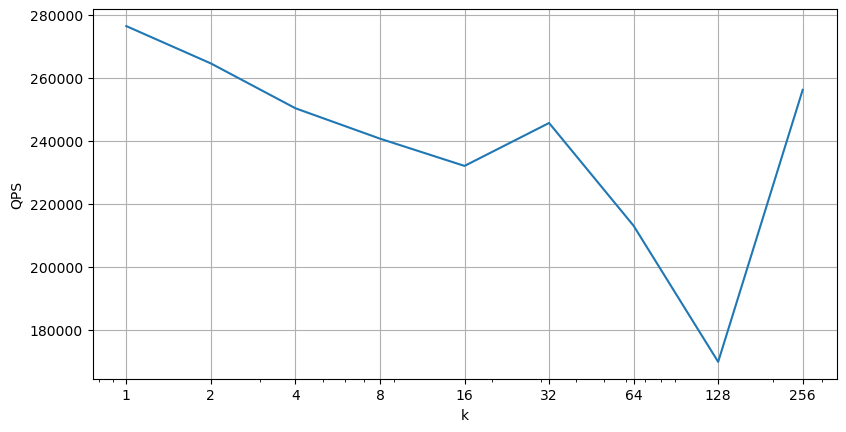

In [17]:
bench_k = np.exp2(np.arange(9)).astype(np.int32)
bench_avg = np.zeros_like(bench_k, dtype=np.float32)
bench_std = np.zeros_like(bench_k, dtype=np.float32)
for i, k in enumerate(bench_k):
    r = %timeit -o ivf_pq.search(search_params, index, queries, k, handle=resources); resources.sync()
    bench_avg[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
    bench_std[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).std()

fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
ax.errorbar(bench_k, bench_avg, bench_std)
ax.set_xscale('log')
ax.set_xticks(bench_k, bench_k)
ax.set_xlabel('k')
ax.grid()
ax.set_ylabel('QPS');

#### Number of probes
IVF-PQ search runs in two phases; first it looks for nearest clusters,
then it searches for the neighbors in every selected cluster.

We can set how many clusters we want to inspect.
For this, `ivf_pq.SearchParams` has a parameter `n_probes`.
This is the core parameter to control the QPS/recall trade-off.

In [18]:
bench_probes = np.exp2(np.arange(9)).astype(np.int32)
bench_qps = np.zeros_like(bench_probes, dtype=np.float32)
bench_recall = np.zeros_like(bench_probes, dtype=np.float32)
k = 100
for i, n_probes in enumerate(bench_probes):
    sp = ivf_pq.SearchParams(n_probes=n_probes)
    r = %timeit -o ivf_pq.search(sp, index, queries, k, handle=resources); resources.sync()
    bench_qps[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
    bench_recall[i] = calc_recall(ivf_pq.search(sp, index, queries, k, handle=resources)[1], gt_neighbors)
    

4.13 ms ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.29 ms ± 5.24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.3 ms ± 5.51 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
24.9 ms ± 8.64 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.3 ms ± 17 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
91 ms ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
176 ms ± 29 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
340 ms ± 93.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
658 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


It's clear that the search time scales almost linearly with the number of probes.
This is due to the algorithm spending most of the time in the second phase scanning through individual clusters.
Thanks to the balanced nature of the clustering k-means algorithm, the sizes of the clusters are roughly similar;
hence the linear relation `n_probes` ~ query time.

Let's draw some plots to illustrate how the number of probes affects QPS and recall.

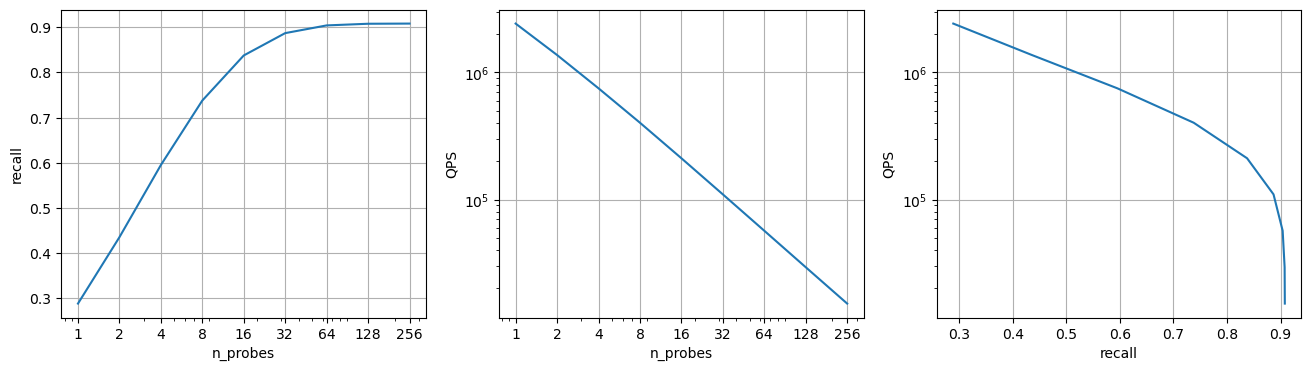

In [19]:
fig, ax = plt.subplots(1, 3, figsize=plt.figaspect(1/4))

ax[0].plot(bench_probes, bench_recall)
ax[0].set_xscale('log')
ax[0].set_xticks(bench_probes, bench_probes)
ax[0].set_xlabel('n_probes')
ax[0].set_ylabel('recall')
ax[0].grid()

ax[1].plot(bench_probes, bench_qps)
ax[1].set_xscale('log')
ax[1].set_xticks(bench_probes, bench_probes)
ax[1].set_xlabel('n_probes')
ax[1].set_ylabel('QPS')
ax[1].set_yscale('log')
ax[1].grid()

ax[2].plot(bench_recall, bench_qps)
ax[2].set_xlabel('recall')
ax[2].set_ylabel('QPS')
ax[2].set_yscale('log')
ax[2].grid();

#### Internal search types
Besides `n_probes`, `ivf_pq.SearchParams` contains a couple more parameters, which affect the internal workings of the algorithm.

`internal_distance_dtype` controls the representation of the distance/similarity during the search.
By default, it's `np.float32`, but you can change it to `np.float16` when appropriate to save the memory bandwidth.
This can be a good idea when the dataset type is low precision anyway (e.g. `np.uint8`),
yet it may help with 32-bit float datasets too.

`lut_dtype` is the Look-Up Table Data Type.
The specifics of the PQ algorithm is that it stores the data in the Product Quantizer (PQ) encoded format,
which needs to be decoded during the second-phase (in-cluster) search.
Thus, the algorithm constructs a lookup table for each cluster.
This is a costly operation, and the table itself can be rather large.
By default, the individual elements in the table are stored as 32-bit floats,
but you can change this to `np.float16` or `np.uint8` to reduce the table size.

The exact size of the table is as follows:

$ \mathtt{lut\_size} = \mathtt{pq\_dim} \cdot \mathtt{sizeof(lut\_dtype) \cdot 2^{\mathtt{pq\_bits}}} $

Ideally, the lookup table should fit in the shared memory of a GPU's multiprocessor,
but it's not the case for wider datasets.
The logic of deciding whether this table should stay in the shared or the global memory of the GPU is somewhat complicated.
Yet, you can see the outcome when you gradually change `pq_dim` and observe a sudden drop in QPS after a certain threshold.
The shared-memory kernel version is typically 2-5x faster than the global-memory version.

However `pq_dim` strongly affects the recall and requires the index to be re-build on change.
This is where `lut_dtype` comes in handy: you can halve or quarter the lookup table size by changing it.
Though it does affect the recall too.

Also note, it does not make sense to set the `lut_dtype` to a more precise type than `internal_distance_dtype`,
as the former is converted to the latter internally.


In [20]:
bench_qps_s1 = np.zeros((5,), dtype=np.float32)
bench_recall_s1 = np.zeros((5,), dtype=np.float32)
k = 10
n_probes = 256
search_params_32_32 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float32, lut_dtype=np.float32)
search_params_32_16 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float32, lut_dtype=np.float16)
search_params_32_08 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float32, lut_dtype=np.uint8)
search_params_16_16 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float16, lut_dtype=np.float16)
search_params_16_08 = ivf_pq.SearchParams(n_probes=n_probes, internal_distance_dtype=np.float16, lut_dtype=np.uint8)
search_ps = [search_params_32_32, search_params_32_16, search_params_32_08, search_params_16_16, search_params_16_08]
bench_names = ['32/32', '32/16', '32/8', '16/16', '16/8']

for i, sp in enumerate(search_ps):
    r = %timeit -o ivf_pq.search(sp, index, queries, k, handle=resources); resources.sync()
    bench_qps_s1[i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
    bench_recall_s1[i] = calc_recall(ivf_pq.search(sp, index, queries, k, handle=resources)[1], gt_neighbors)

503 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
376 ms ± 93 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
295 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
356 ms ± 63.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
286 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


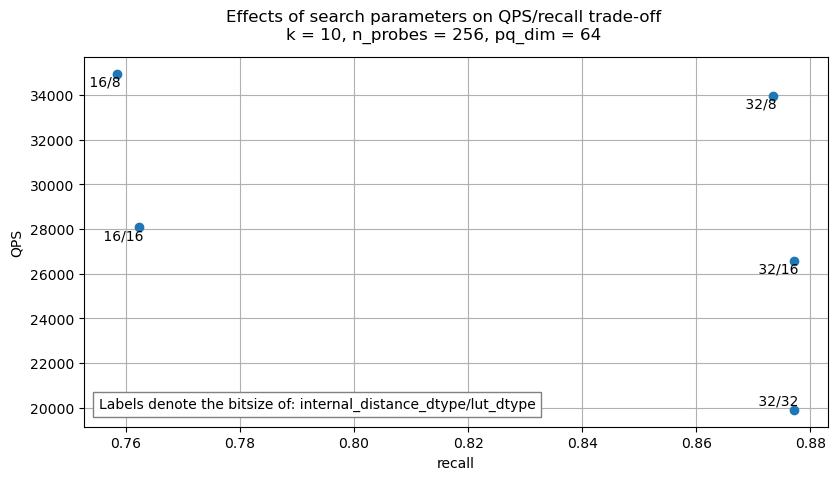

In [27]:
fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
fig.suptitle(
    f'Effects of search parameters on QPS/recall trade-off\n' + \
    f'k = {k}, n_probes = {n_probes}, pq_dim = {pq_dim}')
ax.plot(bench_recall_s1, bench_qps_s1, 'o')
ax.set_xlabel('recall')
ax.set_ylabel('QPS')
ax.grid()
annotations = []
for i, label in enumerate(bench_names):
    annotations.append(ax.text(
        bench_recall_s1[i], bench_qps_s1[i],
        f" {label} ",
        ha='center', va='center'))
clutter = [
    ax.text(
        0.02, 0.08,
        'Labels denote the bitsize of: internal_distance_dtype/lut_dtype',
        verticalalignment='top',
        bbox={'facecolor': 'white', 'edgecolor': 'grey'},
        transform = ax.transAxes)
]
adjust_text(annotations, objects=clutter);

This figure represents the trade-offs one does by choosing different combintations of the internal search types (the bit sizes of the data types are shown as point labels).
Depending on the GPU and the selected dataset, you may see different pictures.
With SIFT-128 (`pq_dim = 64`), reducing the `internal_distance_dtype` comes at a huge cost to recall,
whereas `lut_dtype` doesn't cost too much while significantly improving QPS.

Also, often you may see `16/16` version being faster than `16/8`.
This indicates that ALU is the bottleneck in this configuration, and a few extra ALU operations for converting between fp8 and fp16 do more harm than the saved L1 bandwidth does good for the performance.


Let's try the same experiment, but with refinement.
We'll try ratio 2 and 4 and see how it affects recall and QPS.

In [28]:
def search_refine(ps, ratio):
    k_search = k * ratio
    candidates = ivf_pq.search(ps, index, queries, k_search, handle=resources)[1]
    return candidates if ratio == 1 else refine(dataset, queries, candidates, k, handle=resources)[1]

ratios = [1, 2, 4]
bench_qps_sr = np.zeros((len(ratios), len(search_ps)), dtype=np.float32)
bench_recall_sr = np.zeros((len(ratios), len(search_ps)), dtype=np.float32)

for j, ratio in enumerate(ratios): 
    for i, ps in enumerate(search_ps):
        r = %timeit -o search_refine(ps, ratio); resources.sync()
        bench_qps_sr[j, i] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
        bench_recall_sr[j, i] = calc_recall(search_refine(ps, ratio), gt_neighbors)

503 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
376 ms ± 85.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
294 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
356 ms ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
286 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
609 ms ± 329 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
504 ms ± 302 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
466 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
491 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
421 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
676 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
542 ms ± 420 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
448 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
514 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
464 ms ± 424 µs per loop (mean ± std. dev. of 7 runs, 1 l

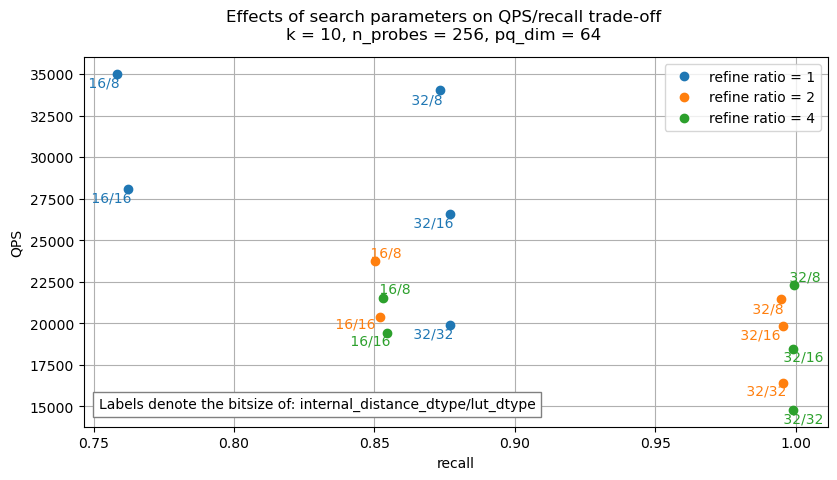

In [29]:
fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
fig.suptitle(
    f'Effects of search parameters on QPS/recall trade-off\n' + \
    f'k = {k}, n_probes = {n_probes}, pq_dim = {pq_dim}')
labels = []
for j, ratio in enumerate(ratios):
    ax.plot(bench_recall_sr[j, :], bench_qps_sr[j, :], 'o')
    labels.append(f"refine ratio = {ratio}")
ax.legend(labels)
ax.set_xlabel('recall')
ax.set_ylabel('QPS')
ax.grid()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
annotations = []
for j, ratio in enumerate(ratios):
    for i, label in enumerate(bench_names):
        annotations.append(ax.text(
            bench_recall_sr[j, i], bench_qps_sr[j, i],
            f" {label} ",
            color=colors[j],
            ha='center', va='center'))
clutter = [
    ax.text(
        0.02, 0.08,
        'Labels denote the bitsize of: internal_distance_dtype/lut_dtype',
        verticalalignment='top',
        bbox={'facecolor': 'white', 'edgecolor': 'grey'},
        transform = ax.transAxes)
]
adjust_text(annotations, objects=clutter);

Depending on the dataset, you may see very different pictures here. For SIFT-128, we pick three interesting candidates candidates featuring compromizes between the QPS and the recall:
  - `internal_distance_dtype = 16, lut_dtype = 16`
  - `internal_distance_dtype = 32, lut_dtype = 8`
  - `internal_distance_dtype = 32, lut_dtype = 8, refine_ratio = 2`

This is all for the search parameters, but we will come back to the look-up table question in the next section.

In [30]:
def search_refine(internal_distance_dtype, lut_dtype, ratio, n_probes):
    k_search = k * ratio
    ps = ivf_pq.SearchParams(
        n_probes=n_probes,
        internal_distance_dtype=internal_distance_dtype,
        lut_dtype=lut_dtype)
    candidates = ivf_pq.search(ps, index, queries, k_search, handle=resources)[1]
    return candidates if ratio == 1 else refine(dataset, queries, candidates, k, handle=resources)[1]

search_configs = [
    lambda n_probes: search_refine(np.float16, np.float16, 1, n_probes),
    lambda n_probes: search_refine(np.float32, np.uint8, 1, n_probes),
    lambda n_probes: search_refine(np.float32, np.uint8, 2, n_probes)
]
search_config_names = [
    '16/16', '32/8', '32/8/r2'
]

## Tweaking indexing parameters


Deciding on the indexing parameters is a bit more involved than on the search parameters. This is obviously because `ivf_pq.IndexParams` has more members than `ivf_pq.SearchParams`, but also because the try-test loop takes longer time when it includes training.
Since RAFT's IVF-PQ algorithm uses balanced-hierarchical k-means clustering and efficient logic for encoding, we find significantly improved index build times.

First of all, let's pick the parameters we __don't need__ to tweak:

  - `metric` - the distance metric often depens on the problem and thus fixed (currently RAFT supports variations of eucliean and inner product distances).
  - `conservative_memory_allocation` only affects how data is allocated - does not affect the search performance.
  - `add_data_on_build` is a convenience flag. When activated, it automatically adds the training data to the index during `ivf_pq.build`. Otherwise, no data is added during `ivf_pq.build` and vectors need to be explicitly added to the index using `ivf_pq.extend`.
  - `force_random_rotation` may slightly affect performance when the data dimensionality is a power of two (see the module docs), but normally you don't need to change the defaults. 

The rest of the parameters can be divided in two categories: influencing the coarse search (`kmeans_n_iters`, `kmeans_trainset_fraction` , `n_lists`) and the fine search / product quantization (`codebook_kind`, `pq_dim`, `pq_bits`).

### Indexing parameters affecting the coarse search

#### n_lists

`n_lists` is the first parameter to look at. It has a profound impact on overall performance during both training and search.
`n_lists` defines the number of clusters into which the index data is partitioned; you should keep this in mind when selecting the `n_probes` search parameter.

The ratio `n_probes/n_lists` tells how large fraction of the dataset is compared to each query. If `n_lists == n_probes`, that is like a brute force search: we compare all dataset vectors to all query vectors. One would expect the recall is equal to `1` in such a case, but that does not take into account the PQ compression, which is lossy; in reality the recall is always lower unless you refine the search results.

As `n_probes` approaches `n_lists`, IVF-PQ becomes slower than brute force because of all the extra work the algorithm does: dimension padding / transform, two-step search, extra PQ compute, etc. In practice searching around 0.1-1% of lists is enough for many datasets. But this depends on how well the input can be clustered. (e.g. for uniform random numbers as inputs, IVF methods don't work well).

`n_lists = sqrt(n_samples)` is a good starting point for the balance of coarse/fine search time. To make sure the GPU resources are utilized efficiently, keep in mind:
  - The average cluster size (i.e. `n_smaples / n_lists`) should be in the range of at least ~2k records to keep individual SMs busy
  - Total amount of search work (`n_queries * n_probes`) should be a good multiple of number of SMs


In [31]:
n_list_variants = [100, 500, 1000, 2000, 5000]
pl_ratio_variants = [500, 200, 100, 50, 10, 5]
selected_search_variant = 1
search_fun = search_configs[selected_search_variant]
search_label = search_config_names[selected_search_variant]

bench_qps_nl = np.zeros((len(n_list_variants), len(pl_ratio_variants)), dtype=np.float32)
bench_recall_nl = np.zeros_like(bench_qps_nl, dtype=np.float32)

for i, n_lists in enumerate(n_list_variants):
    index_params = ivf_pq.IndexParams(n_lists=n_lists, metric=metric, pq_dim=pq_dim)
    index = ivf_pq.build(index_params, dataset, handle=resources)
    for j, pl_ratio in enumerate(pl_ratio_variants):
        n_probes = max(1, n_lists // pl_ratio)
        r = %timeit -o search_fun(n_probes);  resources.sync()
        bench_qps_nl[i, j] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
        bench_recall_nl[i, j] = calc_recall(search_fun(n_probes), gt_neighbors)

5.44 ms ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.45 ms ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.45 ms ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.75 ms ± 20.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
38.4 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
72 ms ± 88.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.43 ms ± 4.75 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.12 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.87 ms ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.3 ms ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
73.2 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
142 ms ± 494 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.55 ms ± 12 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.37 ms ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.6

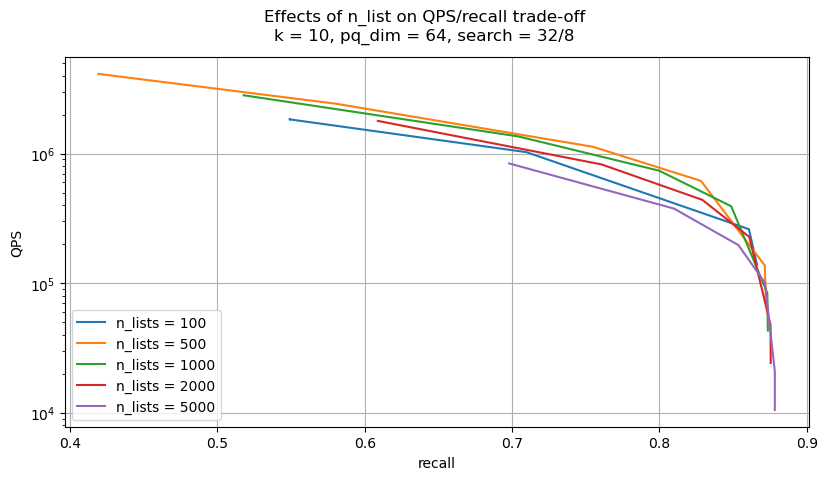

In [33]:
fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
fig.suptitle(
    f'Effects of n_list on QPS/recall trade-off\n' + \
    f'k = {k}, pq_dim = {pq_dim}, search = {search_label}')
labels = []
for i, n_lists in enumerate(n_list_variants):
    ax.plot(bench_recall_nl[i, :], bench_qps_nl[i, :])
    labels.append(f"n_lists = {n_lists}")

ax.legend(labels)
ax.set_xlabel('recall')
ax.set_ylabel('QPS')
ax.set_yscale('log')
ax.grid()

This chart demonstrates that for the given data set (SIFT-128) and the selected parameters, the QPS/recall curves are rather close to each other.
Yet, two lines, which correspond to 100- and 5000-cluster indices, lag below the others.
This suggests that 5000 clusters is probably too many and 100 clusters is probably too few for this dataset. In the range of 500-2000 the algorithm performs very similar though.
Hence, you shouldn't worry about finding the exact single best value of `n_lists`, but rather make sure it's within a reasonable range.


#### kmeans_trainset_fraction

This parameter defines how much of the original data should be fed into training.
This is useful when in conjunction with `add_data_on_build = True`.
For example, having a 100M-record dataset, it's reasonable to set `kmeans_trainset_fraction = 0.1` to train the index (i.e. run the k-means clustering) using 10M records only (10% of data), and then add the whole dataset to the index.
Hence, this parameter directly affects the training speed, but can indirectly affect the search performance (depending on how well the training set represents the full dataset).

Note, if `add_data_on_build = False`, setting the trainset fraction less than one is identical to passing a smaller dataset to the `ivf_pq.build`.

#### kmeans_n_iters

This parameter is passed directly to the k-means algorithm during training. It's set to a reasonable default of 20, which works for most datasets. However, once in a while you may see a warning complaining that the trained clusters are imbalanced. You can try to fix that by increasing the number of iterations.

### Indexing parameters affecting the fine search / product quantization

In the IVF-PQ index, a database vector y is approximated with two level quantization:

$ y = Q_1(y) + Q_2(y - Q_1(y)) $

The first level quantizer ($Q_1$), maps the vector y to the nearest cluster center. The number of
clusters is `n_lists`.

The second quantizer encodes the residual, and it is defined as a product quantizer
(see [_"Product quantization for nearest neighbor search" by Herve Jegou, Matthijs Douze, Cordelia Schmid_](https://www.researchgate.net/publication/47815472_Product_Quantization_for_Nearest_Neighbor_Search)).

A product quantizer encodes a `dim` dimensional vector with a `pq_dim` dimensional vector.
First we split the input vector into `pq_dim` subvectors (denoted by u), where each u vector
contains `pq_len` distinct components of y
```
y_1, y_2, ... y_{pq_len}, y_{pq_len+1}, ... y_{2*pq_len}, ... y_{dim-pq_len+1} ... y_{dim}
 \___________________/     \____________________________/      \______________________/
        u_1                         u_2                          u_{pq_dim}
```
Then each subvector encoded with a separate quantizer $q_i$, end the results are concatenated

$ Q_2(y) = q_1(u_1),q_2(u_2),...,q_\mathtt{pq\_dim}(u_\mathtt{pq\_dim}) $

Each quantizer $q_i$ outputs a code with `pq_bit` bits. The second level quantizers are also defined
by k-means clustering in the corresponding sub-space: the reproduction values are the centroids,
and the set of reproduction values is the codebook.

During the search, for every query and probed list, a look-up table (LUT) is constructed using appropriate codebooks and the query coordinates.
The size of the LUT has profound effect on the performance; here it is one more time:

$ \mathtt{lut\_size} = \mathtt{pq\_dim} \cdot \mathtt{sizeof(lut\_dtype) \cdot 2^{\mathtt{pq\_bits}}} $

If possible, the LUT is stored fully in GPU L1 (shared) memory during search;
otherwise, a slower version of the kernel is used, which stores the LUT in the global memory.


#### codebook_kind

The second-level quantizers are trained either for each subspace or for each cluster, controlled by parameter `codebook_kind`:

  1. "subspace" (C++ api: `codebook_gen::PER_SUBSPACE`): \
        creates `pq_dim` second-level quantizers - one for each slice of the data along features;
  2. "cluster" (C++ api: `codebook_gen::PER_CLUSTER`): \
        creates `n_lists` second-level quantizers - one for each first-level cluster.

In either case, the centroids are found using k-means clustering interpreting the data as having `pq_len` dimensions.

There's no definitive way to tell in advance, which of the two options yields better performance for a particular use case.
A few observations, however, may help:

  - A per-cluster codebook tends to take more time to train, since `n_lists` is usually much higher than `pq_dim` - more codebooks to train.
  - Search with a per-cluster codebook usually utilizes L1 cache of the GPU better than with a per-subspace codebook; this may result in a faster search when the LUT is big and occupies a large part of the GPU L1 memory.
  - However, in practice, the recall is slightly higher with a per-subspace codebook.


#### pq_dim, pq_bits

`pq_dim` parameter is the main way to control the compression in the database.
You should choose it depending on your expectations about the sparsity of the information in the data.
As an experiment, you could start with `pq_dim` in the range of the data dimensionality `[dim / 2, dim]`.

`pq_bits` is the number of bits in a single PQ code.
Hence, it controls the codebook size - $2^{\mathtt{pq\_bits}}$ - the number of possible values a code can take.
IVF-PQ supports the codebooks sizes from 16 to 256, or the `pq_bits` in the range of `[4, 8]`.

`pq_bits` affects the compression: a database with `pq_bits = 4` is twice smaller than with the `pq_bits = 8`.
Though much stronger `pq_bits` affects the LUT size, as the LUT size is proportional to $2^{\mathtt{pq\_bits}}$ (see the formula above).
This also means a drastic effect on the recall.

A few observations:

  - It's required that `(pq_dim * pq_bits) % 8 == 0`; in general, keeping `pq_dim` in powers of two improves the search performance due to better data alignment.
  - Keeping `pq_dim * pq_bits >= 128` and `(pq_dim * pq_bits) % 32 == 0` maximizes the GPU memory bandwidth utilization.
  - Generally `pq_bits = 8` is a good starting point.
  - The recall loss due to smaller `pq_bits` can be compensated by enabling refinement.
  - For high-dimensional data and large `pq_dims`, lowering `pq_bits` can yield a drastic search speedup due to enabling the faster kernel that keeps the LUT in L1.
  - Alternatively, setting the search parameter `lut_dtype` to `uint8` may be enough to keep the LUT in L1.



In [34]:
# Let's try a few build configurations.
#   Warning: this will take some time

k = 10
n_probes_variants = [10, 20, 50, 100]
n_lists = 1000

build_configs = {
    '64-8-subspace': ivf_pq.IndexParams(n_lists=n_lists, metric=metric, pq_dim=64, pq_bits=8, codebook_kind="subspace"),
    '128-8-subspace': ivf_pq.IndexParams(n_lists=n_lists, metric=metric, pq_dim=128, pq_bits=8, codebook_kind="subspace"),
    '128-6-subspace': ivf_pq.IndexParams(n_lists=n_lists, metric=metric, pq_dim=128, pq_bits=6, codebook_kind="subspace"),
    '128-6-cluster': ivf_pq.IndexParams(n_lists=n_lists, metric=metric, pq_dim=128, pq_bits=6, codebook_kind="cluster"),
}

bench_qps_ip = np.zeros((len(build_configs), len(search_configs), len(n_probes_variants)), dtype=np.float32)
bench_recall_ip = np.zeros_like(bench_qps_ip, dtype=np.float32)

for i, index_params in enumerate(build_configs.values()):
    index = ivf_pq.build(index_params, dataset, handle=resources)
    for l, search_fun in enumerate(search_configs):
        for j, n_probes in enumerate(n_probes_variants):
            r = %timeit -o search_fun(n_probes);  resources.sync()
            bench_qps_ip[i, l, j] = (queries.shape[0] * r.loops / np.array(r.all_runs)).mean()
            bench_recall_ip[i, l, j] = calc_recall(search_fun(n_probes), gt_neighbors)

15.9 ms ± 3.18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
30.4 ms ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
72.9 ms ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
143 ms ± 24.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.5 ms ± 46.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.7 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
60.7 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
119 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
158 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
171 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
209 ms ± 369 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
273 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
27.9 ms ± 6.22 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
53.6 ms ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
128 ms ± 16.9 µs per 

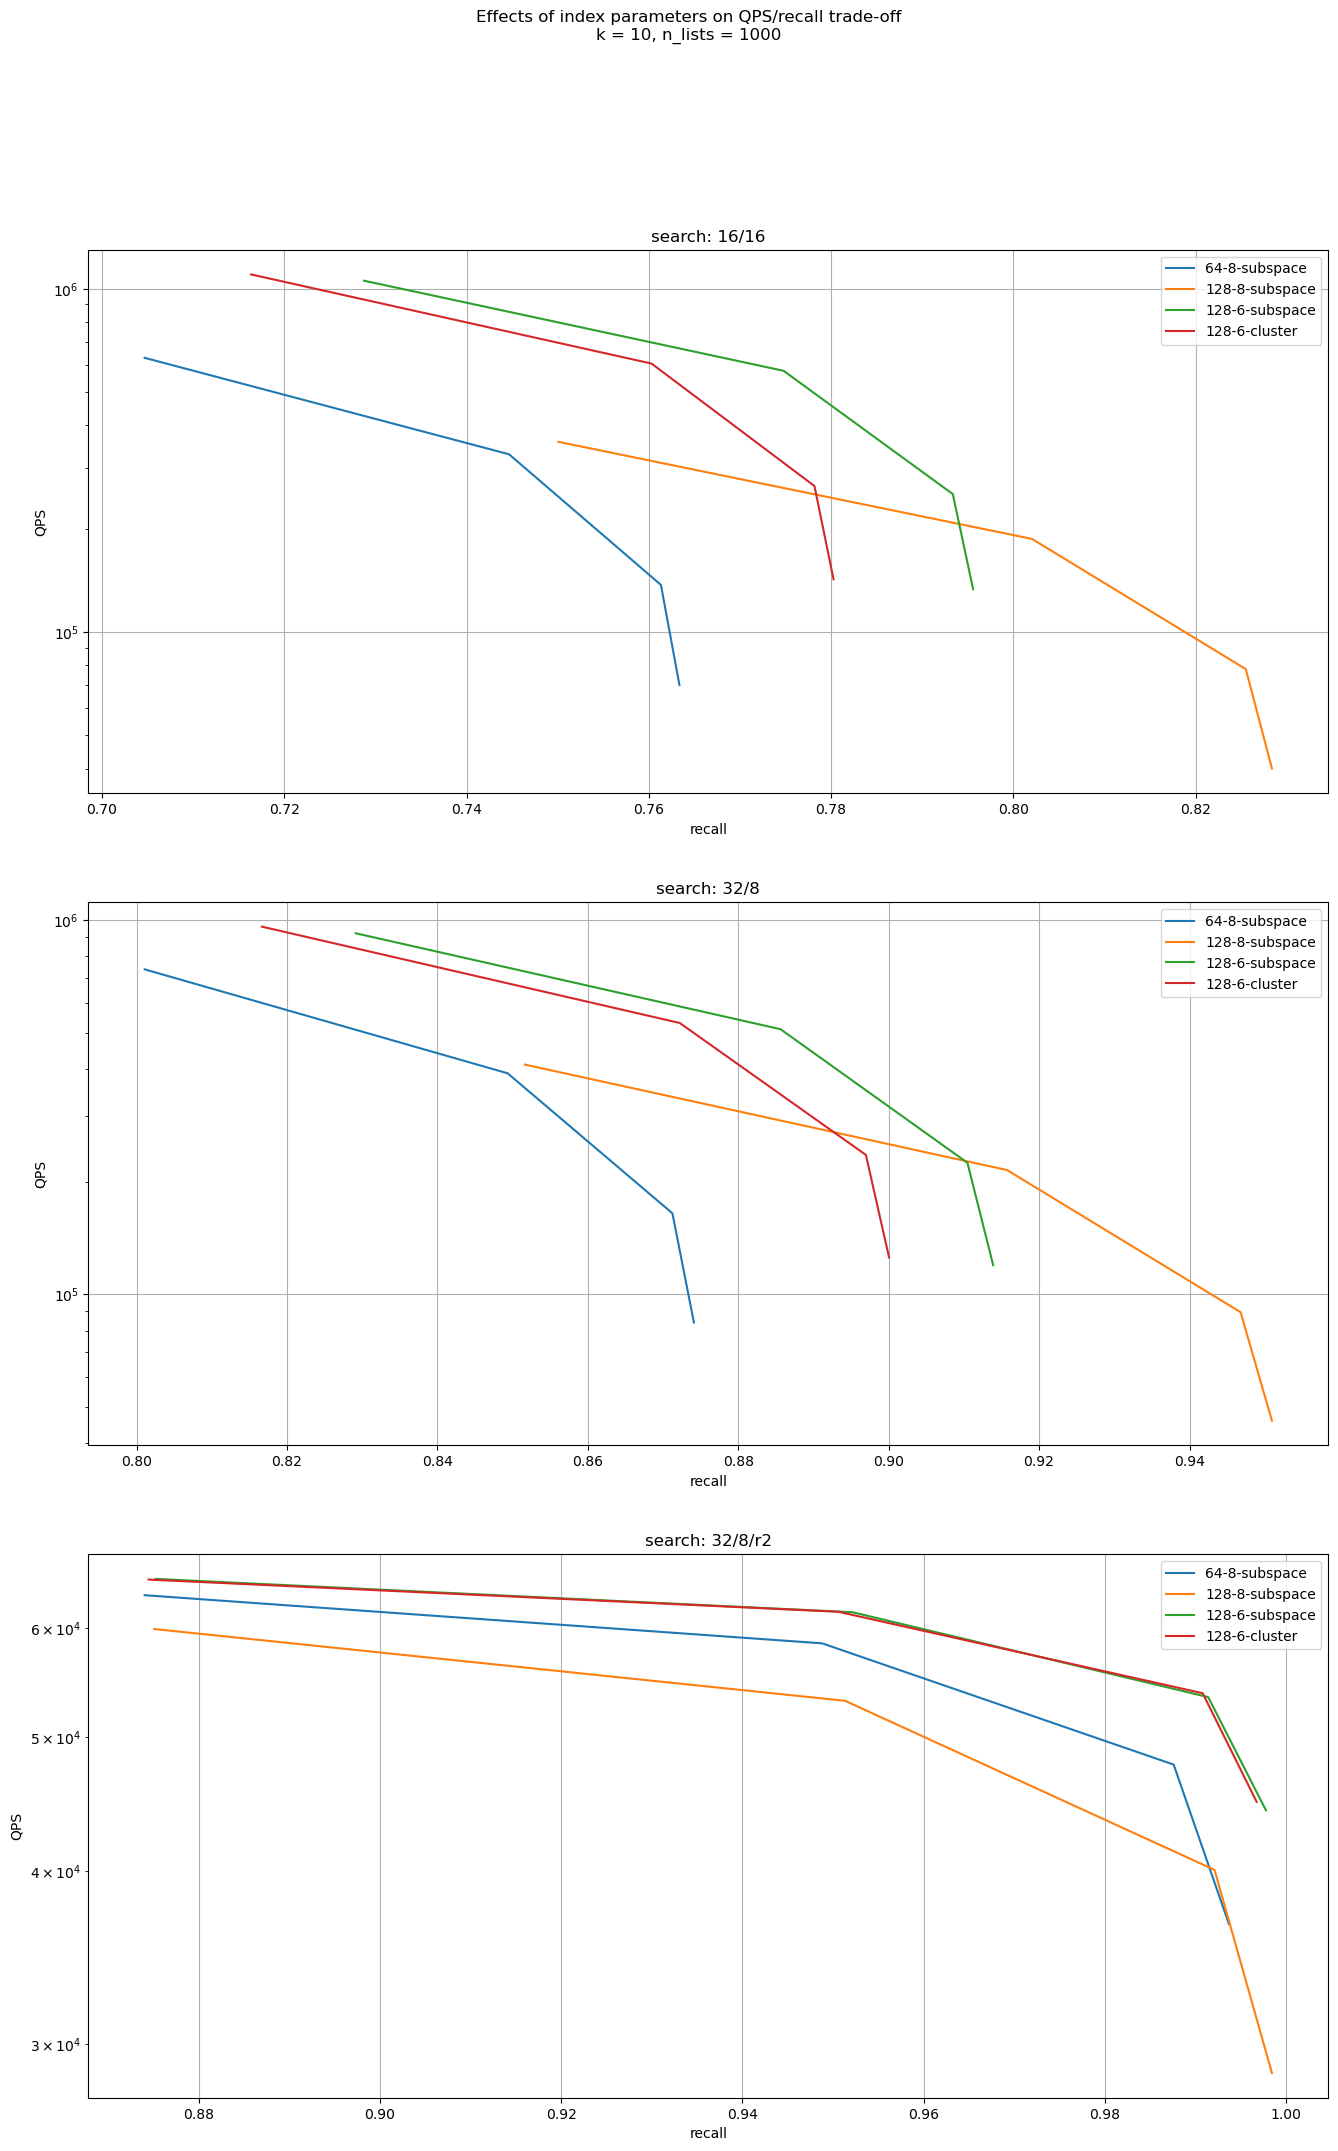

In [36]:
fig, ax = plt.subplots(len(search_config_names), 1, figsize=(16, len(search_config_names)*8))
fig.suptitle(
    f'Effects of index parameters on QPS/recall trade-off\n' + \
    f'k = {k}, n_lists = {n_lists}')

for j, search_label in enumerate(search_config_names):
    labels = []
    for i, index_label in enumerate(build_configs.keys()):
        ax[j].plot(bench_recall_ip[i, j, :], bench_qps_ip[i, j, :])
        labels.append(index_label)

    ax[j].set_title(f"search: {search_label}")
    ax[j].legend(labels)
    ax[j].set_xlabel('recall')
    ax[j].set_ylabel('QPS')
    ax[j].set_yscale('log')
    ax[j].grid()